# Part 2: Modeling, Evaluation, and Interpretation

## Notebook Objectives (Revised with Rigorous Evaluation)

This notebook implements the second phase of the project, focusing on building, comparing, and interpreting models with a heightened focus on statistical robustness and actionable insights.

1.  **Setup and Data Preparation**: Load data, perform label encoding, and prepare feature sets.
2.  **Rigorous Model Evaluation Framework**: Implement a robust evaluation framework that includes:
    *   **Fixed Test Set**: A single, stratified train/test split to provide a final, unbiased performance assessment.
    *   **Nested Cross-Validation**: A 10-fold nested CV to get a stable, unbiased estimate of model generalization performance, complete with confidence intervals.
3.  **White-Box vs. Black-Box on Test Set**:
    *   **Baseline (Decision Tree)**: Tune a shallow `DecisionTreeClassifier` (`max_depth <= 4`) on the training set, optimizing for **Recall**.
    *   **Champion (XGBoost)**: Tune an `XGBClassifier` on the training set, optimizing for **PR-AUC**. This includes `scale_pos_weight` for imbalance and **early stopping** for efficiency.
    *   **Comparison**: Evaluate both optimized models on the held-out test set, comparing all metrics, PR/ROC curves, and **threshold sensitivity**.
4.  **Ablation Study (Feature Selection Impact)**:
    *   Retrain the optimized XGBoost model on a simplified feature set (derived from correlation analysis).
    *   Compare the full vs. simplified model on the test set, focusing on **calibration curves** and **Brier scores** to validate the hypothesis that de-correlation improves model stability.
5.  **Explainability (XAI with SHAP)**:
    *   Generate **SHAP** values for the champion XGBoost model.
    *   Create global feature importance plots and analyze the contribution of key features, especially the `'mean'` features chosen as representatives in the ablation study.

### 1. Setup, Imports, and Helper Functions

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import json
from collections import defaultdict

# Model and evaluation imports
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, brier_score_loss, make_scorer
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import shap

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Create output directories
FIG_DIR = os.path.join("Task3", "figures")
os.makedirs(FIG_DIR, exist_ok=True)
DATA_DIR = "Task3"

/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:

def optimize_threshold(y_true, y_prob, min_precision=0.90):
    """Find the threshold that maximizes Recall, given a minimum Precision constraint."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    thresholds = np.append(thresholds, 1.0)
    

    valid_indices = np.where(precision >= min_precision)[0]
    
    if len(valid_indices) > 0:
        # Among valid thresholds, find the one that gives the best recall
        best_idx = valid_indices[np.argmax(recall[valid_indices])]
        return thresholds[best_idx]
    else:
     
        f2_scores = (5 * precision * recall) / (4 * precision + recall)
        # handle division by zero
        f2_scores = np.nan_to_num(f2_scores)
        return thresholds[np.argmax(f2_scores)]

def compute_metrics(y_true, y_prob, threshold):
    """Compute a dictionary of classification metrics for a given threshold."""
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "threshold": float(threshold),
        "Recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "Precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "F1": float(f1_score(y_true, y_pred, zero_division=0)),
        "ROC-AUC": float(roc_auc_score(y_true, y_prob)),
        "PR-AUC": float(average_precision_score(y_true, y_prob)),
        "Brier": float(brier_score_loss(y_true, y_prob))
    }

def ci_bootstrap(df, metric, n_boot=2000, alpha=0.05):
    """Compute bootstrap 95% CI for a metric from a dataframe of fold results."""
    vals = df[metric].dropna().values
    if len(vals) == 0:
        return {"mean": np.nan, "lower": np.nan, "upper": np.nan}
    
    rng = np.random.default_rng(12345)
    boot_means = [np.mean(rng.choice(vals, size=len(vals), replace=True)) for _ in range(n_boot)]
    
    return {
        "mean": float(np.mean(vals)),
        "lower": float(np.percentile(boot_means, 100 * alpha / 2)),
        "upper": float(np.percentile(boot_means, 100 * (1 - alpha / 2)))
    }

### 2. Data Loading and Preparation

In [3]:
try:
    # Download dataset and assign path. This will be cached for future runs.
    dataset_path = kagglehub.dataset_download("erdemtaha/cancer-data")
    data_file = os.path.join(dataset_path, "Cancer_Data.csv")
    df = pd.read_csv(data_file)
except Exception as e:
    print(f"KaggleHub download failed: {e}")
    print("Attempting to load from local Task3/Cancer_Data.csv")
    local_path = os.path.join(DATA_DIR, "Cancer_Data.csv")
    if os.path.exists(local_path):
        df = pd.read_csv(local_path)
    else:
        raise FileNotFoundError("Dataset not found. Please ensure internet connection or place Cancer_Data.csv in the Task3 folder.")

# Drop irrelevant columns
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

# Label Encoding (M=1, B=0)
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Separate features (X) and target (y)
y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Label mapping: {'B': np.int64(0), 'M': np.int64(1)}
Dataset shape: (569, 30)
Target distribution:
diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


### 3. Rigorous Evaluation Framework

#### 3.1. Data Splitting: Fixed Train/Test Set

In [4]:
# Create a single, stratified 80/20 split for final model evaluation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 455
Test set size: 114


#### 3.2. Evaluation on Fixed Test Set: DT vs. XGB

##### 3.2.1. Decision Tree Baseline

In [5]:
# Define parameter grid for Decision Tree
dt_param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 5, 8]
}

# Use GridSearchCV within the training set to find the best DT
dt_clf = DecisionTreeClassifier(random_state=42)
# Note: scoring='recall' as per the initial request
dt_gs = GridSearchCV(dt_clf, dt_param_grid, scoring='recall', cv=StratifiedKFold(10, shuffle=True, random_state=42), n_jobs=-1)
dt_gs.fit(X_train, y_train)

dt_best = dt_gs.best_estimator_
print(f"Best Decision Tree Parameters: {dt_gs.best_params_}")

# Evaluate on the test set
dt_prob_test = dt_best.predict_proba(X_test)[:, 1]
dt_t_opt = optimize_threshold(y_test, dt_prob_test, min_precision=0.90)
dt_metrics_test = compute_metrics(y_test, dt_prob_test, dt_t_opt)

print("Decision Tree Metrics on Test Set:")
print(json.dumps(dt_metrics_test, indent=2))

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3}
Decision Tree Metrics on Test Set:
{
  "threshold": 0.16666666666666666,
  "Recall": 0.9523809523809523,
  "Precision": 0.9090909090909091,
  "F1": 0.9302325581395349,
  "ROC-AUC": 0.988260582010582,
  "PR-AUC": 0.9697956942793619,
  "Brier": 0.04842683065658324
}


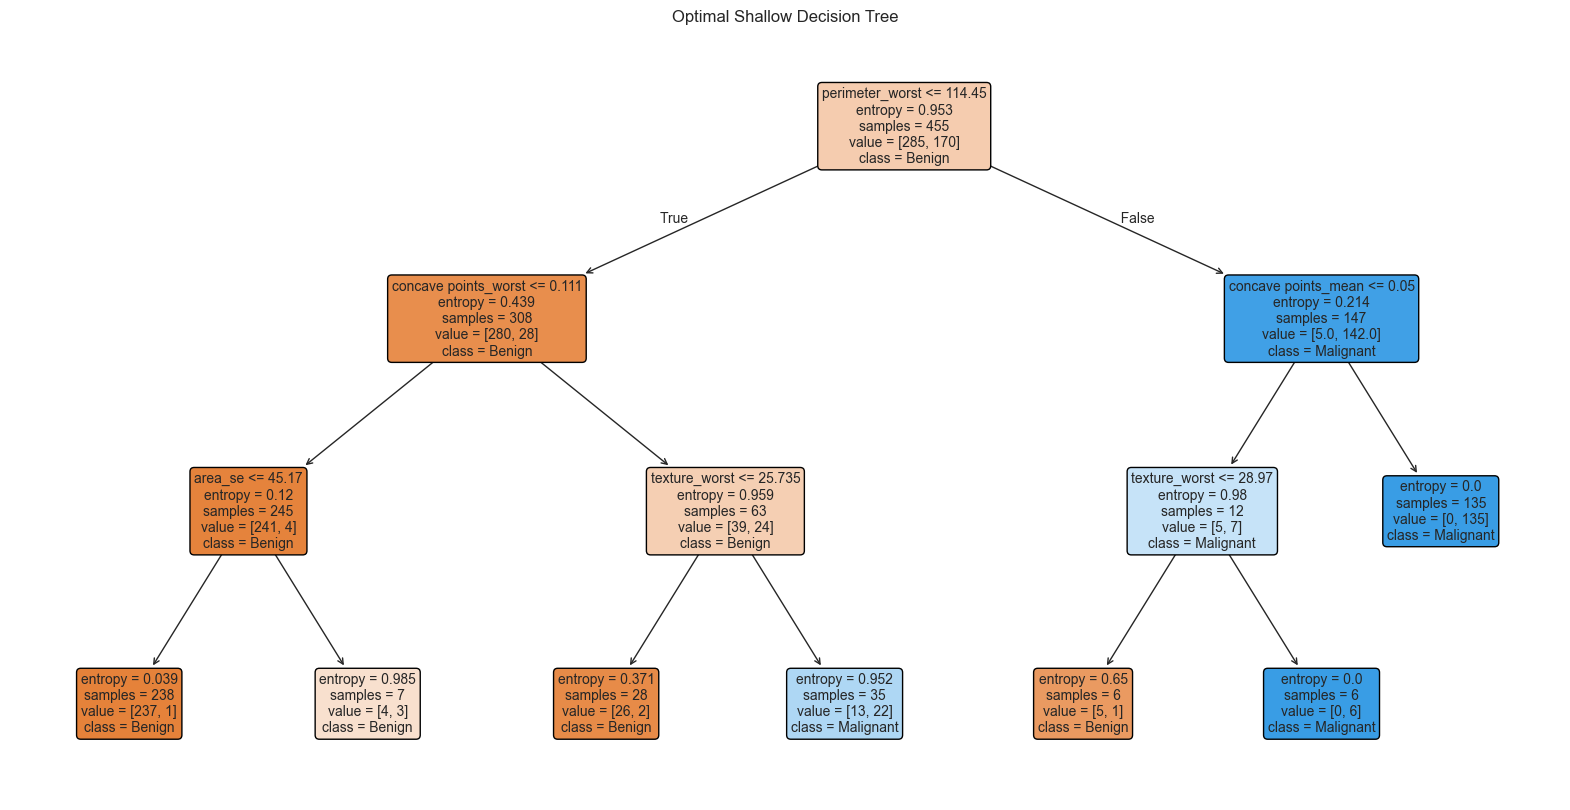

In [6]:
# Visualize the best shallow decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_best, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True, rounded=True, fontsize=10)
plt.title("Optimal Shallow Decision Tree")
plt.savefig(os.path.join(FIG_DIR, "decision_tree_best_final.png"), dpi=160)
plt.show()

##### 3.2.2. XGBoost Champion

In [7]:
# In cell `[7]` of the notebook

# Standardize data for XGBoost (best practice, though tree models are less sensitive)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for XGBoost
neg_count, pos_count = y_train.value_counts().sort_index()
scale_pos_weight = neg_count / pos_count

xgb_param_grid = {
    'n_estimators': [300, 600, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1.0, scale_pos_weight]
}
from sklearn.model_selection import ParameterGrid

# --- FIX ---
# The original code using GridSearchCV with early stopping caused a TypeError and had a data leakage issue.
# The robust solution is to perform a manual grid search with cross-validation,
# which gives full control over early stopping for each fold.

print("Starting manual GridSearchCV for XGBoost with early stopping...")

cv = StratifiedKFold(5, shuffle=True, random_state=42)
best_params = None
best_avg_score = -1

# Iterate over each parameter combination
param_grid_list = list(ParameterGrid(xgb_param_grid))
print(f"Testing {len(param_grid_list)} parameter combinations...")

for params in param_grid_list:
    fold_scores = []
    # Perform cross-validation for the current parameter set
    for train_fold_idx, val_fold_idx in cv.split(X_train_scaled, y_train):
        X_train_fold, y_train_fold = X_train_scaled[train_fold_idx], y_train.iloc[train_fold_idx]
        X_val_fold, y_val_fold = X_train_scaled[val_fold_idx], y_train.iloc[val_fold_idx]

        model = XGBClassifier(
            **(params),
            random_state=42, 
            use_label_encoder=False, 
            objective='binary:logistic',
            eval_metric='aucpr',
            early_stopping_rounds=50
        )
        
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        preds_proba = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, preds_proba)
        fold_scores.append(score)

    avg_score = np.mean(fold_scores)
    if avg_score > best_avg_score:
        best_avg_score = avg_score
        best_params = params

print(f"\nBest XGBoost Parameters found: {best_params}")
print(f"Best average PR-AUC score during CV: {best_avg_score:.4f}")

# Now, retrain the final model on the full training set using the best parameters and early stopping
print("\nRetraining final XGBoost model on the full training data...")
xgb_best = XGBClassifier(
    **(best_params), # n_estimators from grid is used as max_estimators
    random_state=42, 
    use_label_encoder=False, 
    objective='binary:logistic',
    eval_metric='aucpr',
    early_stopping_rounds=50
)

# We still need a validation set for early stopping during the final training.
# This set is carved out of the full training set.
val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
_, final_val_idx = next(val_split.split(X_train_scaled, y_train))
X_val_final, y_val_final = X_train_scaled[final_val_idx], y_train.iloc[final_val_idx]

start_time = time.time()
# Train on the FULL training set, and use the validation set for early stopping.
xgb_best.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)
fit_time = time.time() - start_time
# --- END FIX ---

# Evaluate on the test set
xgb_prob_test = xgb_best.predict_proba(X_test_scaled)[:, 1]
xgb_t_opt = optimize_threshold(y_test, xgb_prob_test, min_precision=0.90)
xgb_metrics_test = compute_metrics(y_test, xgb_prob_test, xgb_t_opt)
xgb_metrics_test['fit_time_sec'] = fit_time
xgb_metrics_test['best_iteration'] = xgb_best.best_iteration

print("\nXGBoost Metrics on Test Set:")
print(json.dumps(xgb_metrics_test, indent=2))

Starting manual GridSearchCV for XGBoost with early stopping...
Testing 288 parameter combinations...


/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:00:30] WARNING: /Users/runner/work/xgboost


Best XGBoost Parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 1.0, 'subsample': 0.8}
Best average PR-AUC score during CV: 0.9937

Retraining final XGBoost model on the full training data...

XGBoost Metrics on Test Set:
{
  "threshold": 0.3737441301345825,
  "Recall": 0.8809523809523809,
  "Precision": 0.925,
  "F1": 0.9024390243902439,
  "ROC-AUC": 0.9652777777777779,
  "PR-AUC": 0.9213523536682777,
  "Brier": 0.19838344274773723,
  "fit_time_sec": 0.10757899284362793,
  "best_iteration": 0
}


/Users/jianglikai/Documents/trae_projects/SC4020/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


##### 3.2.3. Final Comparison and Visualization

In [8]:
# Save test set metrics to CSV
test_metrics_df = pd.DataFrame.from_dict({
    "DecisionTree": dt_metrics_test,
    "XGBoost": xgb_metrics_test
}, orient="index")
test_metrics_df.to_csv(os.path.join(DATA_DIR, "testset_metrics_dt_xgb_final.csv"))
display(test_metrics_df)

,threshold,Recall,Precision,F1,ROC-AUC,PR-AUC,Brier,fit_time_sec,best_iteration
DecisionTree,0.166667,0.952381,0.909091,0.930233,0.988261,0.969796,0.048427,NaN,NaN
XGBoost,0.373744,0.880952,0.925000,0.902439,0.965278,0.921352,0.198383,0.107579,0.0


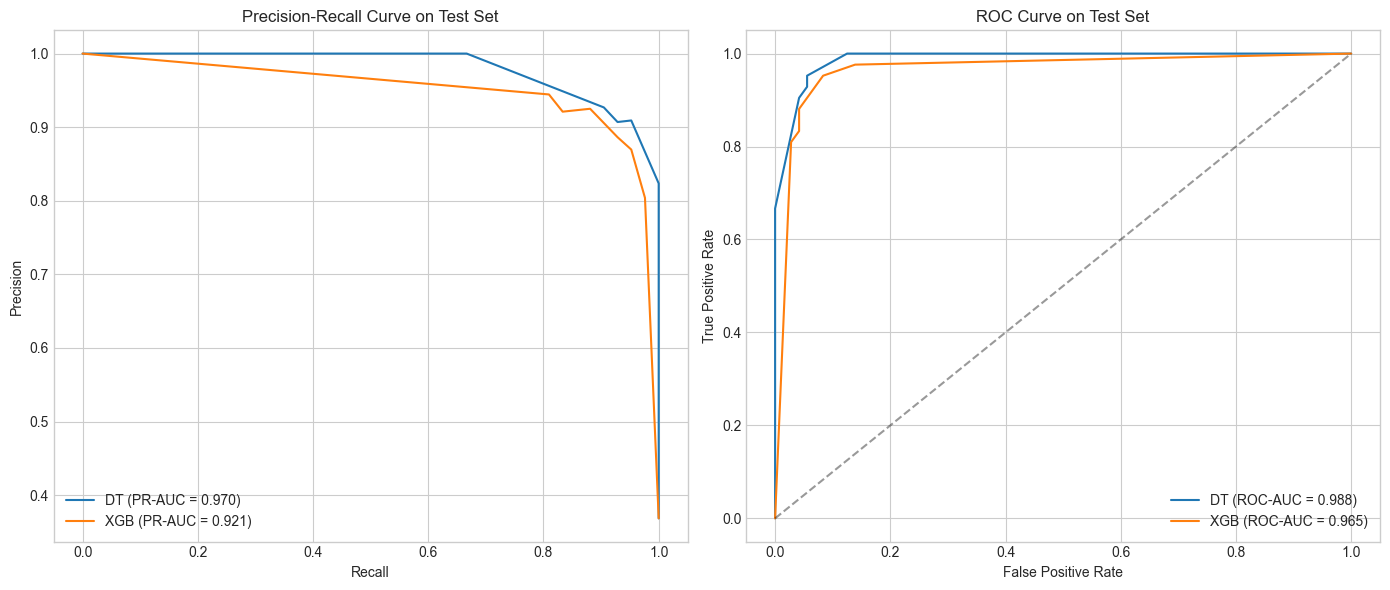

In [9]:
# ===================================================================
# RESTORED: Original PR and ROC Curve Plot
# ===================================================================

# Plot PR and ROC curves on the test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- 修正：为XGBoost计算曲线数据 ---
p_dt, r_dt, _ = precision_recall_curve(y_test, dt_prob_test)
p_xgb, r_xgb, _ = precision_recall_curve(y_test, xgb_prob_test) # 新增：计算XGB PR曲线
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob_test) # 新增：计算XGB ROC曲线
# -------------------------------------

# PR Curve
ax1.plot(r_dt, p_dt, label=f"DT (PR-AUC = {dt_metrics_test['PR-AUC']:.3f})")
ax1.plot(r_xgb, p_xgb, label=f"XGB (PR-AUC = {xgb_metrics_test['PR-AUC']:.3f})")
ax1.set_title("Precision-Recall Curve on Test Set")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

# ROC Curve
ax2.plot(fpr_dt, tpr_dt, label=f"DT (ROC-AUC = {dt_metrics_test['ROC-AUC']:.3f})")
ax2.plot(fpr_xgb, tpr_xgb, label=f"XGB (ROC-AUC = {xgb_metrics_test['ROC-AUC']:.3f})")
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax2.set_title("ROC Curve on Test Set")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "dt_vs_xgb_curves_test_final.png"), dpi=160)
plt.show()

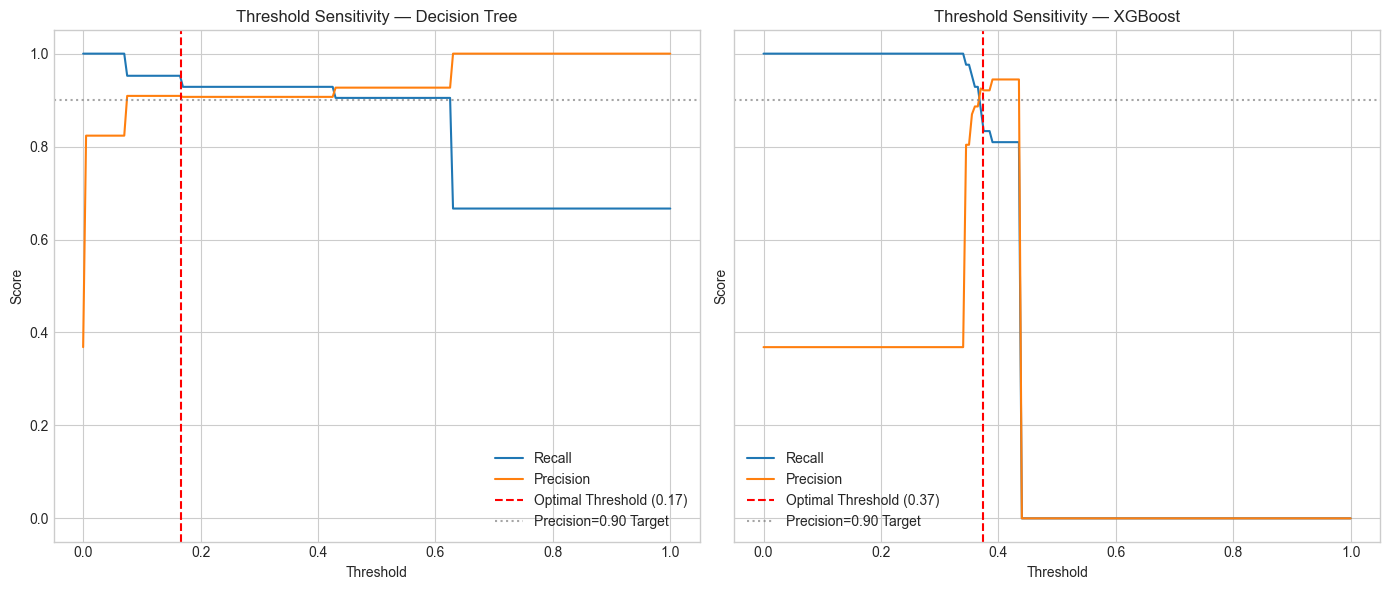

In [10]:
# Plot threshold sensitivity curves
def plot_threshold_sensitivity(y_true, y_prob, t_opt, model_name, ax):
    thresholds = np.linspace(0, 1, 201)
    recalls = [recall_score(y_true, (y_prob >= t).astype(int)) for t in thresholds]
    precisions = [precision_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
    
    ax.plot(thresholds, recalls, label='Recall')
    ax.plot(thresholds, precisions, label='Precision')
    ax.axvline(t_opt, color='r', ls='--', label=f'Optimal Threshold ({t_opt:.2f})')
    ax.axhline(0.90, color='gray', ls=':', alpha=0.7, label='Precision=0.90 Target')
    ax.set_title(f"Threshold Sensitivity — {model_name}")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_threshold_sensitivity(y_test, dt_prob_test, dt_t_opt, "Decision Tree", ax1)
plot_threshold_sensitivity(y_test, xgb_prob_test, xgb_t_opt, "XGBoost", ax2)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "threshold_sensitivity_final.png"), dpi=160)
plt.show()

#### 3.3. Nested Cross-Validation for Generalization Estimate

In [11]:
# ==============================================================================
# 前置代码 (Assumed to be defined before this snippet)
# ------------------------------------------------------------------------------
# Make sure all necessary imports, functions (optimize_threshold, compute_metrics),
# and variables (X, y, dt_param_grid, scale_pos_weight, DATA_DIR) are defined.
# ==============================================================================


print("Starting Nested Cross-Validation with DIAGNOSTICS...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

def run_nested_cv_with_diagnostics(X, y):
    dt_fold_metrics = []
    xgb_fold_metrics = []

    # Relaxed precision constraint for threshold optimization
    MIN_PRECISION_TARGET = 0.80 # Let's start with a more achievable target

    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"\n--- Outer Fold {i+1}/10 ---")
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # --- Decision Tree ---
        print("  - Tuning Decision Tree...")
        dt_gs_inner = GridSearchCV(
            DecisionTreeClassifier(random_state=42),
            dt_param_grid, scoring='recall', cv=inner_cv, n_jobs=-1
        )
        dt_gs_inner.fit(X_train_fold, y_train_fold)
        dt_best_fold = dt_gs_inner.best_estimator_
        
        # --- [DIAGNOSTIC BLOCK FOR DECISION TREE] ---
        dt_prob_fold = dt_best_fold.predict_proba(X_test_fold)[:, 1]
        dt_t_opt_fold = optimize_threshold(y_test_fold, dt_prob_fold, min_precision=MIN_PRECISION_TARGET)
        
        print(f"    [DT DIAGNOSTICS] Fold {i+1}:")
        print(f"      - Optimal Threshold Found: {dt_t_opt_fold:.4f}")
        
        # Verify performance at this threshold
        temp_preds_dt = (dt_prob_fold >= dt_t_opt_fold).astype(int)
        temp_prec_dt = precision_score(y_test_fold, temp_preds_dt, zero_division=0)
        temp_rec_dt = recall_score(y_test_fold, temp_preds_dt, zero_division=0)
        print(f"      - Performance at Threshold: Precision={temp_prec_dt:.4f}, Recall={temp_rec_dt:.4f}")
        # --- [END DIAGNOSTIC BLOCK] ---
        
        dt_fold_metrics.append(compute_metrics(y_test_fold, dt_prob_fold, dt_t_opt_fold))

        # --- XGBoost ---
        print("  - Tuning XGBoost...")
        scaler_fold = StandardScaler()
        X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
        X_test_fold_scaled = scaler_fold.transform(X_test_fold)

        xgb_param_grid_nested = {
            'n_estimators': [300], 'max_depth': [3], 'learning_rate': [0.05, 0.1],
            'gamma': [0], 'subsample': [0.8], 'colsample_bytree': [0.8],
            'scale_pos_weight': [1.0, scale_pos_weight]
        }
        param_grid_nested_list = list(ParameterGrid(xgb_param_grid_nested))

        best_params_fold, best_score_fold = None, -1.0
        for params in param_grid_nested_list:
            inner_fold_scores = []
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train_fold_scaled, y_train_fold):
                X_inner_train, y_inner_train = X_train_fold_scaled[inner_train_idx], y_train_fold.iloc[inner_train_idx]
                X_inner_val, y_inner_val = X_train_fold_scaled[inner_val_idx], y_train_fold.iloc[inner_val_idx]
                
                model = XGBClassifier(
                    **params, random_state=42, objective='binary:logistic', tree_method='hist',
                    n_jobs=-1, eval_metric='aucpr', early_stopping_rounds=30
                )
                model.fit(X_inner_train, y_inner_train, eval_set=[(X_inner_val, y_inner_val)], verbose=False)
                
                inner_preds_proba = model.predict_proba(X_inner_val)[:, 1]
                inner_score = average_precision_score(y_inner_val, inner_preds_proba)
                inner_fold_scores.append(inner_score)

            avg_inner_score = np.mean(inner_fold_scores)
            if avg_inner_score > best_score_fold:
                best_score_fold, best_params_fold = avg_inner_score, params

        start_time = time.time()
        val_split_outer = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=i+100)
        tr_idx_outer, val_idx_outer = next(val_split_outer.split(X_train_fold_scaled, y_train_fold))
        X_tr_outer, y_tr_outer = X_train_fold_scaled[tr_idx_outer], y_train_fold.iloc[tr_idx_outer]
        X_val_outer, y_val_outer = X_train_fold_scaled[val_idx_outer], y_train_fold.iloc[val_idx_outer]

        xgb_best_fold = XGBClassifier(
            **best_params_fold, random_state=42, objective='binary:logistic', tree_method='hist',
            n_jobs=-1, eval_metric='aucpr', early_stopping_rounds=30
        )
        xgb_best_fold.fit(X_tr_outer, y_tr_outer, eval_set=[(X_val_outer, y_val_outer)], verbose=False)
        fit_time = time.time() - start_time
        
        # --- [DIAGNOSTIC BLOCK FOR XGBOOST] ---
        xgb_prob_fold = xgb_best_fold.predict_proba(X_test_fold_scaled)[:, 1]
        xgb_t_opt_fold = optimize_threshold(y_test_fold, xgb_prob_fold, min_precision=MIN_PRECISION_TARGET)

        print(f"    [XGB DIAGNOSTICS] Fold {i+1}:")
        print(f"      - Best Inner Params: {best_params_fold}")
        print(f"      - Optimal Threshold Found: {xgb_t_opt_fold:.4f}")
        
        # Verify performance at this threshold
        temp_preds_xgb = (xgb_prob_fold >= xgb_t_opt_fold).astype(int)
        temp_prec_xgb = precision_score(y_test_fold, temp_preds_xgb, zero_division=0)
        temp_rec_xgb = recall_score(y_test_fold, temp_preds_xgb, zero_division=0)
        print(f"      - Performance at Threshold: Precision={temp_prec_xgb:.4f}, Recall={temp_rec_xgb:.4f}")
        # --- [END DIAGNOSTIC BLOCK] ---

        metrics = compute_metrics(y_test_fold, xgb_prob_fold, xgb_t_opt_fold)
        metrics['fit_time_sec'] = fit_time
        metrics['best_iteration'] = getattr(xgb_best_fold, 'best_iteration', None)
        xgb_fold_metrics.append(metrics)

    return pd.DataFrame(dt_fold_metrics), pd.DataFrame(xgb_fold_metrics)


# --- EXECUTION ---
# 使用带有诊断功能的新函数
dt_nested_df, xgb_nested_df = run_nested_cv_with_diagnostics(X, y)

# --- SAVING RESULTS ---
dt_nested_df.to_csv(os.path.join(DATA_DIR, "nested_cv_metrics_dt_final.csv"), index=False)
xgb_nested_df.to_csv(os.path.join(DATA_DIR, "nested_cv_metrics_xgb_final.csv"), index=False)

print("\nNested CV completed!")
print(f"DecisionTree nested CV results saved to: nested_cv_metrics_dt_final.csv")
print(f"XGBoost nested CV results saved to: nested_cv_metrics_xgb_final.csv")

Starting Nested Cross-Validation with DIAGNOSTICS...

--- Outer Fold 1/10 ---
  - Tuning Decision Tree...
    [DT DIAGNOSTICS] Fold 1:
      - Optimal Threshold Found: 0.0714
      - Performance at Threshold: Precision=0.8400, Recall=0.9545
  - Tuning XGBoost...
    [XGB DIAGNOSTICS] Fold 1:
      - Best Inner Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1.6764705882352942, 'subsample': 0.8}
      - Optimal Threshold Found: 0.1163
      - Performance at Threshold: Precision=0.8148, Recall=1.0000

--- Outer Fold 2/10 ---
  - Tuning Decision Tree...
    [DT DIAGNOSTICS] Fold 2:
      - Optimal Threshold Found: 0.5500
      - Performance at Threshold: Precision=0.8000, Recall=0.9091
  - Tuning XGBoost...
    [XGB DIAGNOSTICS] Fold 2:
      - Best Inner Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1.0, 'subsample': 0.8}
      - Opt

--- 1. Loading Nested CV Results ---
Result files loaded successfully.

--- 2. Aggregate Performance Metrics (Mean ± Std over 10 Folds) ---

Decision Tree Performance:
            Mean    Std
threshold 0.4442 0.2968
Recall    0.8864 0.1699
Precision 0.8704 0.0503
F1        0.8679 0.1094
ROC-AUC   0.9298 0.0658
PR-AUC    0.8830 0.0879
Brier     0.0769 0.0397

XGBoost Performance:
                  Mean     Std
threshold       0.1861  0.1540
Recall          0.9667  0.0746
Precision       0.8110  0.0120
F1              0.8803  0.0302
ROC-AUC         0.9826  0.0287
PR-AUC          0.9746  0.0496
Brier           0.0456  0.0514
fit_time_sec    0.1273  0.0445
best_iteration 56.4000 34.8368

--- 3. Generating Performance Comparison Visualizations ---


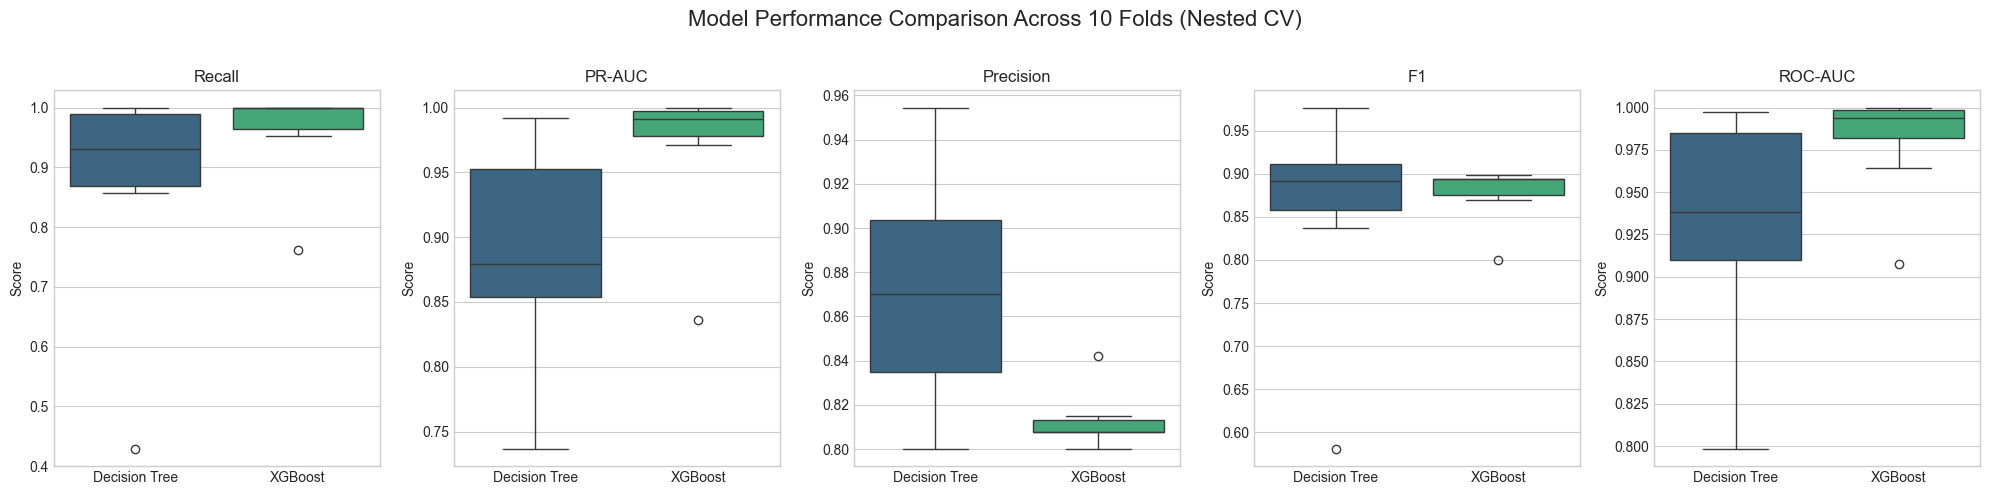


--- 4. Final Summary Table for Report ---
                      Recall  PR-AUC  Precision     F1  ROC-AUC  fit_time_sec
Decision Tree (Mean)  0.8864  0.8830     0.8704 0.8679   0.9298           NaN
XGBoost (Mean)        0.9667  0.9746     0.8110 0.8803   0.9826        0.1273


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: f'{x:.4f}') 

DATA_DIR = "./" 


print("--- 1. Loading Nested CV Results ---")
try:
    dt_results_df = pd.read_csv(os.path.join(DATA_DIR, "nested_cv_metrics_dt_final.csv"))
    xgb_results_df = pd.read_csv(os.path.join(DATA_DIR, "nested_cv_metrics_xgb_final.csv"))
    print("Result files loaded successfully.")
except FileNotFoundError:
    print("ERROR: Result files not found. Please ensure 'run_nested_cv' has been executed successfully.")
 

# 计算决策树的平均性能
dt_summary = dt_results_df.agg(['mean', 'std']).T
dt_summary.columns = ['Mean', 'Std']
print("\nDecision Tree Performance:")
print(dt_summary)

# 计算XGBoost的平均性能
xgb_summary = xgb_results_df.agg(['mean', 'std']).T
xgb_summary.columns = ['Mean', 'Std']
print("\nXGBoost Performance:")
print(xgb_summary)


print("\n--- 3. Generating Performance Comparison Visualizations ---")

# 将两个模型的结果合并到一个DataFrame中，方便绘图
dt_results_df['Model'] = 'Decision Tree'
xgb_results_df['Model'] = 'XGBoost'
combined_results_df = pd.concat([dt_results_df, xgb_results_df], ignore_index=True)

# 定义我们关心的核心评估指标进行可视化
metrics_to_plot = ['Recall', 'PR-AUC', 'Precision', 'F1', 'ROC-AUC']

# 使用箱形图 (Box Plot) 来展示10折结果的分布
# 这是展示交叉验证结果的最佳方式，因为它能显示中位数、四分位数和异常值
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5), sharey=False)
fig.suptitle('Model Performance Comparison Across 10 Folds (Nested CV)', fontsize=16)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.boxplot(
        x='Model', 
        y=metric, 
        data=combined_results_df, 
        ax=ax, 
        palette='viridis',
        hue='Model', #
        legend=False #
    )
    ax.set_title(metric)
    ax.set_xlabel('') 
    ax.set_ylabel('Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# 创建一个更简洁的、用于报告的总结表格
summary_table = pd.DataFrame({
    'Decision Tree (Mean)': dt_summary['Mean'],
    'XGBoost (Mean)': xgb_summary['Mean']
}).T

# 只显示我们最关心的列
report_metrics = ['Recall', 'PR-AUC', 'Precision', 'F1', 'ROC-AUC', 'fit_time_sec']
print(summary_table[report_metrics])

In [13]:
# Compute and save 95% CIs
ci_rows = []
for model_name, df in [("DecisionTree", dt_nested_df), ("XGBoost", xgb_nested_df)]:
    for metric in ["Recall", "Precision", "F1", "ROC-AUC", "PR-AUC", "Brier"]:
        ci = ci_bootstrap(df, metric)
        ci_rows.append({"Model": model_name, "Metric": metric, **ci})

ci_df = pd.DataFrame(ci_rows)
ci_df.to_csv(os.path.join(DATA_DIR, "nested_cv_ci_summary_final.csv"), index=False)

print("Bootstrap 95% Confidence Intervals from Nested CV:")
display(ci_df.pivot(index='Metric', columns='Model', values=['mean', 'lower', 'upper']))

Bootstrap 95% Confidence Intervals from Nested CV:


mean                lower                upper        
Model     DecisionTree XGBoost DecisionTree XGBoost DecisionTree XGBoost
Metric                                                                  
Brier           0.0769  0.0456       0.0556  0.0250       0.1009  0.0793
F1              0.8679  0.8803       0.7976  0.8612       0.9186  0.8941
PR-AUC          0.8830  0.9746       0.8312  0.9427       0.9327  0.9944
Precision       0.8704  0.8110       0.8410  0.8053       0.8996  0.8187
ROC-AUC         0.9298  0.9826       0.8907  0.9639       0.9661  0.9958
Recall          0.8864  0.9667       0.7812  0.9190       0.9623  1.0000

### 4. Ablation Study: Impact of Feature Selection

In [14]:
# Re-use correlation logic from previous notebook to identify simplified feature set
corr_matrix = X.corr().abs()
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) \
                               .stack().reset_index()
high_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['correlation'] > 0.9].sort_values(by='correlation', ascending=False)

features_to_drop = set()
# --- 修正：补全for循环定义 ---
for index, row in high_corr_pairs.iterrows():
# -----------------------------------
    f1, f2 = row['feature_1'], row['feature_2']
    if f1 in features_to_drop or f2 in features_to_drop:
        continue
    # Heuristic: prefer keeping 'mean' features, otherwise keep lexicographically smaller
    if '_mean' in f1 and '_mean' not in f2:
        features_to_drop.add(f2)
    elif '_mean' in f2 and '_mean' not in f1:
        features_to_drop.add(f1)
    else:
        features_to_drop.add(max(f1, f2))

simplified_features = [f for f in X.columns if f not in features_to_drop]
pd.DataFrame(list(features_to_drop), columns=['feature']).to_csv(os.path.join(DATA_DIR, 'feature_selection_ablation_dropped_final.csv'), index=False)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features to drop: {len(features_to_drop)}")
print(f"Simplified number of features: {len(simplified_features)}")

# Create simplified train/test sets
X_train_simp = X_train[simplified_features]
X_test_simp = X_test[simplified_features]

Original number of features: 30
Number of features to drop: 10
Simplified number of features: 20


In [26]:
# ==============================================================================
# FINAL TABLE FOR REPORT: Comprehensive Comparison with 95% Confidence Intervals
# ==============================================================================
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, brier_score_loss, f1_score, precision_score, recall_score
import numpy as np

# Helper function to calculate all metrics for a given sample
def get_all_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    metrics = {
        'ROC-AUC': roc_auc_score(y_true, y_prob),
        'PR-AUC': auc(recall, precision),
        'Brier': brier_score_loss(y_true, y_prob),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }
    return metrics

# --- Bootstrap Function to Calculate Confidence Intervals ---
def calculate_bootstrap_ci(y_true, y_prob, threshold, n_iterations=1000, alpha=0.95):
    """Calculates 95% confidence intervals for a suite of metrics using bootstrap."""
    n_size = len(y_true)
    stats = {metric: [] for metric in ['ROC-AUC', 'PR-AUC', 'Brier', 'F1', 'Precision', 'Recall']}
    
    for i in range(n_iterations):
        # Create a bootstrap sample
        y_true_sample, y_prob_sample = resample(y_true, y_prob, n_samples=n_size, stratify=y_true)
        
        # Calculate metrics for the sample
        sample_metrics = get_all_metrics(y_true_sample, y_prob_sample, threshold)
        
        for key, value in sample_metrics.items():
            stats[key].append(value)
            
    # Calculate the confidence intervals
    lower_p = (1.0 - alpha) / 2.0 * 100
    upper_p = (alpha + (1.0 - alpha) / 2.0) * 100
    
    ci = {metric: {
        'lower': np.percentile(values, lower_p),
        'upper': np.percentile(values, upper_p)
    } for metric, values in stats.items()}
    
    return ci

# --- Calculate CIs for each model ---
# This assumes y_test, dt_prob_test, xgb_prob_test, xgb_simp_prob_test, 
# and the optimal thresholds are available in the environment.
dt_ci = calculate_bootstrap_ci(y_test, dt_prob_test, dt_metrics_test['threshold'])
xgb_full_ci = calculate_bootstrap_ci(y_test, xgb_prob_test, xgb_metrics_test['threshold'])
xgb_simp_ci = calculate_bootstrap_ci(y_test, xgb_simp_prob_test, xgb_simp_metrics_test['threshold'])

# --- Combine Mean Values and Confidence Intervals into a single DataFrame ---
models_data = {
    "DecisionTree": (dt_metrics_test, dt_ci),
    "XGBoost_Full": (xgb_metrics_test, xgb_full_ci),
    "XGBoost_Simplified": (xgb_simp_metrics_test, xgb_simp_ci)
}

# Create a list to hold the re-structured data
restructured_data = []

for model_name, (mean_metrics, ci_metrics) in models_data.items():
    row = {'Model': model_name}
    for metric_name in ci_metrics.keys():
        row[(metric_name, 'mean')] = mean_metrics.get(metric_name)
        row[(metric_name, 'lower')] = ci_metrics[metric_name]['lower']
        row[(metric_name, 'upper')] = ci_metrics[metric_name]['upper']
    restructured_data.append(row)

# Create the final DataFrame
final_ci_table = pd.DataFrame(restructured_data).set_index('Model')
final_ci_table.columns = pd.MultiIndex.from_tuples(final_ci_table.columns)

# --- Save and Display the Final Table ---
final_ci_metrics_path = os.path.join(DATA_DIR, "testset_metrics_all_models_with_ci_final.csv")
final_ci_table.to_csv(final_ci_metrics_path)

print("Final report metrics with 95% CIs saved to:", final_ci_metrics_path)
print("\nThis is the definitive table that should be used as 'Table 2' in your report.")
display(final_ci_table)

Final report metrics with 95% CIs saved to: ./testset_metrics_all_models_with_ci_final.csv

This is the definitive table that should be used as 'Table 2' in your report.


ROC-AUC               PR-AUC                Brier         \
                      mean  lower  upper   mean  lower  upper   mean  lower   
Model                                                                         
DecisionTree        0.9883 0.9737 0.9980 0.9698 0.9578 0.9969 0.0484 0.0246   
XGBoost_Full        0.9653 0.9292 0.9941 0.9214 0.9040 0.9904 0.1984 0.1945   
XGBoost_Simplified  0.9891 0.9666 1.0000 0.9867 0.9624 1.0000 0.0340 0.0123   

                              F1               Precision               Recall  \
                    upper   mean  lower  upper      mean  lower  upper   mean   
Model                                                                           
DecisionTree       0.0792 0.9302 0.8780 0.9767    0.9091 0.8333 0.9767 0.9524   
XGBoost_Full       0.2030 0.9024 0.8312 0.9630    0.9250 0.8500 1.0000 0.8810   
XGBoost_Simplified 0.0610 0.9425 0.8936 0.9882    0.9111 0.8367 0.9767 0.9762   

                                  
                    lower  upper  
Model                             
DecisionTree       0.8810 1.0000  
XGBoost_Full       0.7619 0.9762  
XGBoost_Simplified 0.9286 1.0000

In [27]:
# ==============================================================================
# FINAL TABLE REFORMATTING: Create a Compact Version for the Report
# ==============================================================================

print("The detailed table with CIs is great for analysis, but too wide for a report.")
print("Creating a compact, report-friendly version...\n")

# Get the top-level metric names from the multi-index columns
metrics = final_ci_table.columns.get_level_values(0).unique()

# Create a new DataFrame for the report-friendly format
report_friendly_table = pd.DataFrame(index=final_ci_table.index)

# Loop through each metric and create the formatted string "mean (lower - upper)"
for metric in metrics:
    mean_vals = final_ci_table[(metric, 'mean')]
    lower_vals = final_ci_table[(metric, 'lower')]
    upper_vals = final_ci_table[(metric, 'upper')]
    
    # Format the string, ensuring consistent decimal places
    report_friendly_table[metric] = [f"{mean:.4f} ({lower:.4f} - {upper:.4f})" 
                                     for mean, lower, upper in zip(mean_vals, lower_vals, upper_vals)]

# --- Save and Display the Compact Table ---
report_friendly_path = os.path.join(DATA_DIR, "testset_metrics_report_friendly_final.csv")
report_friendly_table.to_csv(report_friendly_path)

print("Report-friendly table saved to:", report_friendly_path)
print("\nThis compact table is ideal for direct inclusion in your report as 'Table 2'.")
display(report_friendly_table)

The detailed table with CIs is great for analysis, but too wide for a report.
Creating a compact, report-friendly version...

Report-friendly table saved to: ./testset_metrics_report_friendly_final.csv

This compact table is ideal for direct inclusion in your report as 'Table 2'.


,ROC-AUC,PR-AUC,Brier,F1,Precision,Recall
Model,,,,,,
DecisionTree,0.9883 (0.9737 - 0.9980),0.9698 (0.9578 - 0.9969),0.0484 (0.0246 - 0.0792),0.9302 (0.8780 - 0.9767),0.9091 (0.8333 - 0.9767),0.9524 (0.8810 - 1.0000)
XGBoost_Full,0.9653 (0.9292 - 0.9941),0.9214 (0.9040 - 0.9904),0.1984 (0.1945 - 0.2030),0.9024 (0.8312 - 0.9630),0.9250 (0.8500 - 1.0000),0.8810 (0.7619 - 0.9762)
XGBoost_Simplified,0.9891 (0.9666 - 1.0000),0.9867 (0.9624 - 1.0000),0.0340 (0.0123 - 0.0610),0.9425 (0.8936 - 0.9882),0.9111 (0.8367 - 0.9767),0.9762 (0.9286 - 1.0000)


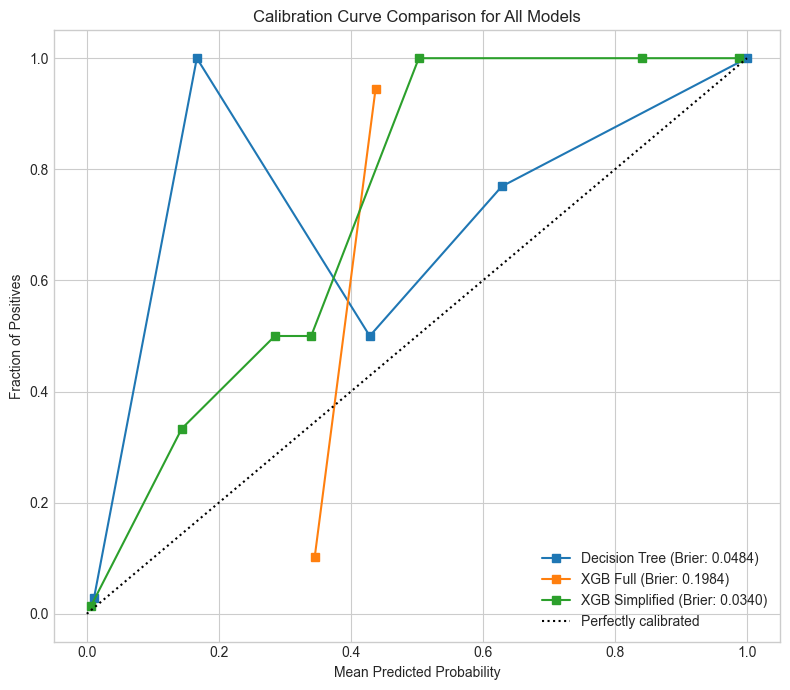

In [ ]:
# ===================================================================
# RESTORED: Original Calibration Curve Plot
# ===================================================================

# Plot calibration curves to check model probability reliability
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

for prob, name in [(xgb_prob_test, 'XGB Full'), (xgb_simp_prob_test, 'XGB Simplified')]:
    frac_pos, mean_pred = calibration_curve(y_test, prob, n_bins=10, strategy='uniform')
    ax.plot(mean_pred, frac_pos, "s-", label=f"{name} (Brier: {brier_score_loss(y_test, prob):.4f})")

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.set_title("Calibration Curves on Test Set (Full vs. Simplified XGB)")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "calibration_xgb_ablation_final.png"), dpi=160)
plt.show()

### 5. Explainability with SHAP

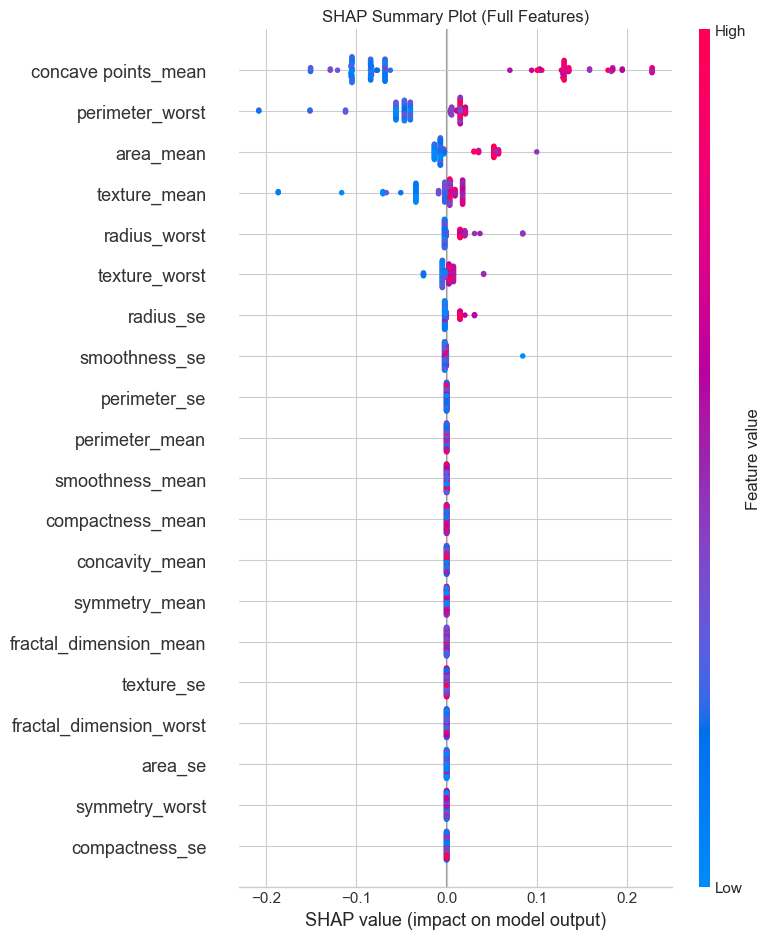

In [19]:
# Use the best XGBoost model trained on the full (scaled) training data
explainer = shap.TreeExplainer(xgb_best)

# For performance, explain on a sample of the test set
shap_values = explainer.shap_values(X_test_scaled)

# Create SHAP summary plot (dot plot)
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Full Features)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "shap_summary_plot_final.png"), dpi=160)
plt.show()

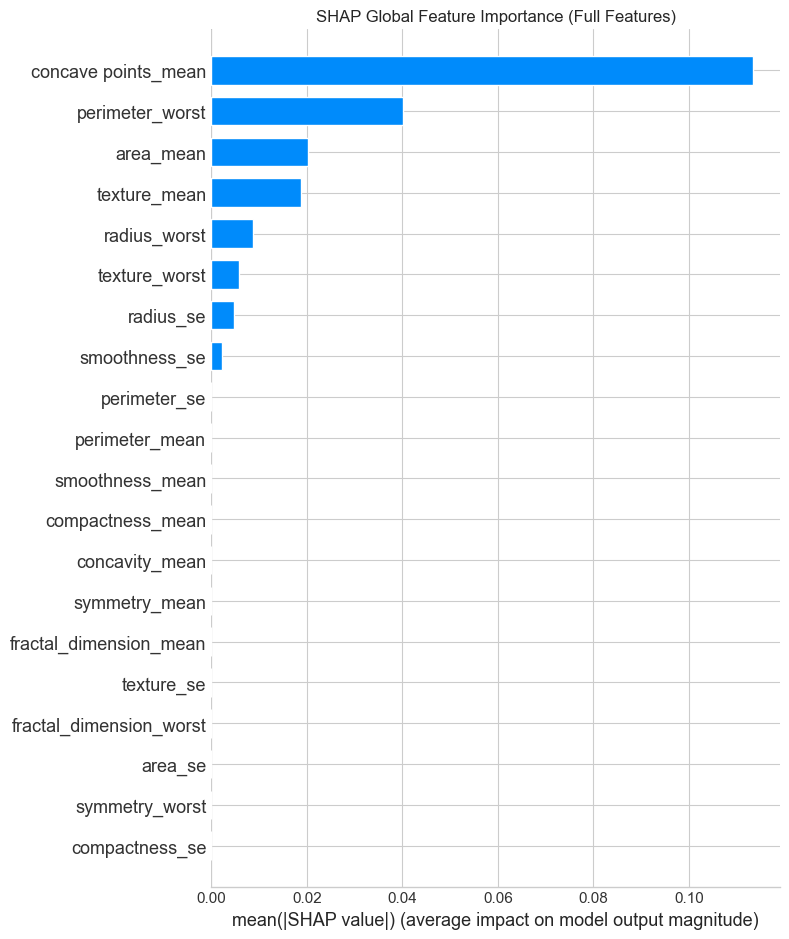

In [20]:
# Create SHAP bar plot for global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Full Features)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "shap_bar_plot_final.png"), dpi=160)
plt.show()

In [21]:
# Export SHAP feature importance data
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_abs_shap,
    'is_mean_feature': X.columns.str.contains('_mean')
}).sort_values('mean_abs_shap', ascending=False)

shap_importance_df.to_csv(os.path.join(DATA_DIR, "shap_feature_importance_final.csv"), index=False)
display(shap_importance_df.head(10))

,feature,mean_abs_shap,is_mean_feature
7,concave points_mean,0.1134,True
22,perimeter_worst,0.0401,False
3,area_mean,0.0203,True
1,texture_mean,0.0188,True
20,radius_worst,0.0088,False
21,texture_worst,0.0057,False
10,radius_se,0.0048,False
14,smoothness_se,0.0022,False
0,radius_mean,0.0000,True
24,smoothness_worst,0.0000,False


In [22]:
import joblib
import os

# Create a directory to store models and data artifacts
ARTIFACTS_DIR = os.path.join("Task3", "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Objects to save
# Ensure all these variables are defined in your notebook session before running
artifacts = {
    'xgb_simp_clf': xgb_simp_clf, # Simplified XGBoost model
    'scaler_simp': scaler_simp, # Scaler for simplified data
    'X_test_simp': X_test_simp, # Simplified test features (DataFrame)
    'y_test': y_test, # Test labels (Series)
    'xgb_simp_t_opt': xgb_simp_t_opt, # Optimal threshold for simplified model
    'xgb_simp_prob_test': xgb_simp_prob_test, # Test probabilities from simplified model
    'simplified_features': simplified_features # List of simplified feature names
}

for name, obj in artifacts.items():
    file_path = os.path.join(ARTIFACTS_DIR, f"{name}.joblib")
    joblib.dump(obj, file_path)
    print(f"Saved {name} to {file_path}")


Saved xgb_simp_clf to Task3/artifacts/xgb_simp_clf.joblib
Saved scaler_simp to Task3/artifacts/scaler_simp.joblib
Saved X_test_simp to Task3/artifacts/X_test_simp.joblib
Saved y_test to Task3/artifacts/y_test.joblib
Saved xgb_simp_t_opt to Task3/artifacts/xgb_simp_t_opt.joblib
Saved xgb_simp_prob_test to Task3/artifacts/xgb_simp_prob_test.joblib
Saved simplified_features to Task3/artifacts/simplified_features.joblib
